In [70]:
from lxml import html  
import requests
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pygal
from IPython.display import SVG, HTML
from pygal.style import DarkSolarizedStyle
from pygal import Config

In [71]:
def get_total_pages(asin):
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.62 Safari/537.36'}
    XPATH_REVIEW_PAGENUM = './/li[@class="page-button"]//text()'
    XPATH_TOTAL_REVIEWS = './/span[@data-hook="total-review-count"]//text()'
    amazon_url = 'https://www.amazon.com/product-reviews/' + asin + '/ref=cm_cr_arp_d_paging_btm_1?pageNumber=1&sortBy=recent'
            # Add some recent user agent to prevent amazon from blocking the request 
            # Find some chrome user agent strings  here https://udger.com/resources/ua-list/browser-detail?browser=Chrome
    page = requests.get(amazon_url, headers=headers)
    page_response = page.text.encode('utf-8')
    parser = html.fromstring(page_response)
    pages = parser.xpath(XPATH_REVIEW_PAGENUM)
    totalreviews = parser.xpath(XPATH_TOTAL_REVIEWS)
    totalreviews = int(totalreviews[0].replace(',','')) 
    maxpage = int(pages[-1].replace(',','')) 
    print('Total pages of reviews: {}'.format(maxpage))
    print('Total number of reviews: {}'.format(totalreviews))
    return maxpage

In [72]:
def scrape_reviews(asins):
    ratings_dict = {}
    reviews_list = []
    reviews_df = pd.DataFrame()

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.62 Safari/537.36'}
    XPATH_REVIEWS = '//div[@data-hook="review"]'
    XPATH_REVIEW_RATING = './/i[@data-hook="review-star-rating"]//text()'
    XPATH_REVIEW_HEADER = './/a[@data-hook="review-title"]//text()'
    XPATH_REVIEW_AUTHOR = './/a[@data-hook="review-author"]//text()'
    XPATH_REVIEW_DATE = './/span[@data-hook="review-date"]//text()'
    XPATH_REVIEW_BODY = './/span[@data-hook="review-body"]//text()'
    XPATH_REVIEW_HELPFUL = './/span[@data-hook="helpful-vote-statement"]//text()'
    XPATH_REVIEW_PAGENUM = './/li[@class="page-button"]//text()'

    p_num = 1
    for asin in asins:
        totalpages = get_total_pages(asin)
        while True:
            print('Scraping review page nr. {}'.format(p_num))
            amazon_url = 'https://www.amazon.com/product-reviews/' + asin + '/ref=cm_cr_arp_d_paging_btm_' +str(p_num) + '?pageNumber=' + str(p_num) + '&sortBy=recent'
            # Add some recent user agent to prevent amazon from blocking the request 
            # Find some chrome user agent strings  here https://udger.com/resources/ua-list/browser-detail?browser=Chrome
            page = requests.get(amazon_url, headers=headers)
            page_response = page.text.encode('utf-8')
            parser = html.fromstring(page_response)
            reviews = parser.xpath(XPATH_REVIEWS)
            
            if not len(reviews) > 0:
                break
            # Parsing individual reviews
            for review in reviews:
                raw_review_author = review.xpath(XPATH_REVIEW_AUTHOR)
                raw_review_rating = review.xpath(XPATH_REVIEW_RATING)
                raw_review_header = review.xpath(XPATH_REVIEW_HEADER)
                raw_review_date = review.xpath(XPATH_REVIEW_DATE)
                raw_review_body = review.xpath(XPATH_REVIEW_BODY)
                raw_review_helpful = review.xpath(XPATH_REVIEW_HELPFUL)

                review_dict = {
                    'review_text': raw_review_body,
                    'review_posted_date': raw_review_date,
                    'review_header': raw_review_header,
                    'review_rating': raw_review_rating,
                    'review_helpful': raw_review_helpful,
                    'review_author': raw_review_author
                }
                reviews_df = reviews_df.append(review_dict, ignore_index=True)
            p_num += 1
            if p_num > totalpages:
                break
    return reviews_df

In [73]:
filename = 'cellphone_1_reviews.pickle'
asins = ['B06Y6J869C']

if os.path.isfile(filename):
    print('Loading reviews from disk') 
    reviews_df = pd.read_pickle(filename)
    print('Loaded {} reviews'.format(len(reviews_df)))
else:
    print('Scraping reviews for item...') 
    reviews_df = scrape_reviews(asins)
    print('Scraped {} reviews'.format(len(reviews_df))) 
    print('Saving reviews to disk') 
    reviews_df.to_pickle(filename)

Loading reviews from disk
Loaded 346 reviews


In [74]:
reviews_df

,review_author,review_header,review_helpful,review_posted_date,review_rating,review_text
0,[Denise Garcia],[Great deal and great item],[],"[on July 23, 2018]",[5.0 out of 5 stars],[Love this phone]
1,[Gary],[Beward of pre-loaded apps!],[],"[on July 22, 2018]",[4.0 out of 5 stars],"[I really do like the phone, but there are way..."
2,[di],[Expensive phones beware],[],"[on July 8, 2018]",[5.0 out of 5 stars],[This phone was an emergency replacement for a...
3,[moleman56],[Should Have Been Great],[],"[on July 3, 2018]",[2.0 out of 5 stars],"[I don't know if all phones have that stupid ""..."
4,[Amazon Customer],[One Star],[One person found this helpful],"[on July 1, 2018]",[1.0 out of 5 stars],[Lasted for 6 months then the screen died.]
5,[Roger],[Virgin schmirgin],[One person found this helpful],"[on June 26, 2018]",[3.0 out of 5 stars],[Ran into some perplexing problems when and af...
6,[Tara],[I like!],[],"[on June 23, 2018]",[4.0 out of 5 stars],[Been a while since I've had an LG phone. I li...
7,[Cynthia Hunter],[Basic phone],[One person found this helpful],"[on June 21, 2018]",[3.0 out of 5 stars],[The speaker on this device is horrible; the v...
8,[Shawn kulhanek],[Not much diffrence from the stylo 2..],[],"[on June 18, 2018]",[4.0 out of 5 stars],[Great phone. But i dont find really anything ...
9,[Carmen G Figueroa],[Very pleased],[],"[on June 11, 2018]",[5.0 out of 5 stars],[Arrived on time and works great]


In [75]:
reviews_df['review_text'][2]

['This phone was an emergency replacement for a samsung.  I kept it. Not wasting hundreds when this phone is thin large screen.. stylus & works great.',
 'Highly recommended']

In [76]:
def format_reviews(reviews_df):
    # convert list to string
    for col in reviews_df.columns:
        reviews_df[col] = reviews_df[col].apply(lambda x: '\n'.join(x))
    reviews_df['review_helpful'] = (reviews_df['review_helpful']
                                    .str.replace('One', '1')
                                    .str.replace(r'[^0-9]', ''))
    reviews_df['review_helpful'].loc[reviews_df['review_helpful'] == ''] = '0'
    reviews_df['review_helpful'] = reviews_df['review_helpful'].astype(int)
    reviews_df['review_posted_date'] = pd.to_datetime(reviews_df['review_posted_date']
                                                      .str.strip('on'))
    reviews_df['review_rating'] = reviews_df['review_rating'].str.strip('out of 5 stars').astype(float)
    reviews_df.loc[reviews_df['review_rating'] == 0, 'review_rating'] = 5
    reviews_df['review_length'] = reviews_df['review_text'].apply(lambda x: len(x))
    reviews_df.drop_duplicates(inplace=True)
    return reviews_df

In [77]:
reviews_df = format_reviews(reviews_df)

In [78]:
reviews_df

,review_author,review_header,review_helpful,review_posted_date,review_rating,review_text,review_length
0,Denise Garcia,Great deal and great item,0,2018-07-23,5.0,Love this phone,15
1,Gary,Beward of pre-loaded apps!,0,2018-07-22,4.0,"I really do like the phone, but there are way,...",406
2,di,Expensive phones beware,0,2018-07-08,5.0,This phone was an emergency replacement for a ...,167
3,moleman56,Should Have Been Great,0,2018-07-03,2.0,"I don't know if all phones have that stupid ""d...",823
4,Amazon Customer,One Star,1,2018-07-01,1.0,Lasted for 6 months then the screen died.,41
5,Roger,Virgin schmirgin,1,2018-06-26,3.0,Ran into some perplexing problems when and aft...,652
6,Tara,I like!,0,2018-06-23,4.0,Been a while since I've had an LG phone. I lik...,300
7,Cynthia Hunter,Basic phone,1,2018-06-21,3.0,The speaker on this device is horrible; the vo...,94
8,Shawn kulhanek,Not much diffrence from the stylo 2..,0,2018-06-18,4.0,Great phone. But i dont find really anything m...,126
9,Carmen G Figueroa,Very pleased,0,2018-06-11,5.0,Arrived on time and works great,31


In [79]:
max_len = reviews_df['review_length'].max()

In [80]:
print(max_len)

6738


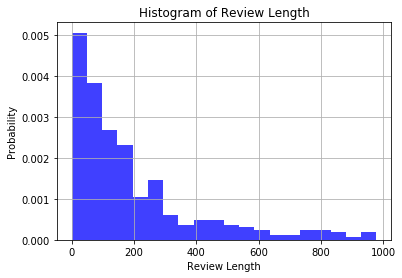

In [81]:
plt.hist(reviews_df['review_length'][reviews_df['review_length'] <= 1000], 20, density=True, facecolor='b', alpha=0.75)
plt.xlabel('Review Length')
plt.ylabel('Probability')
plt.title('Histogram of Review Length')
plt.grid(True)
plt.show()

In [82]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- Bar Graph Demo -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [83]:
bins = np.arange(0, 1001, 50)
bins

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000])

In [84]:
reviews_df['review_length'].head()

0     15
1    406
2    167
3    823
4     41
Name: review_length, dtype: int64

In [85]:
reviews_df['range'] = pd.cut(reviews_df['review_length'], bins, right = True)
reviews_df.head()

,review_author,review_header,review_helpful,review_posted_date,review_rating,review_text,review_length,range
0,Denise Garcia,Great deal and great item,0,2018-07-23,5.0,Love this phone,15,"(0, 50]"
1,Gary,Beward of pre-loaded apps!,0,2018-07-22,4.0,"I really do like the phone, but there are way,...",406,"(400, 450]"
2,di,Expensive phones beware,0,2018-07-08,5.0,This phone was an emergency replacement for a ...,167,"(150, 200]"
3,moleman56,Should Have Been Great,0,2018-07-03,2.0,"I don't know if all phones have that stupid ""d...",823,"(800, 850]"
4,Amazon Customer,One Star,1,2018-07-01,1.0,Lasted for 6 months then the screen died.,41,"(0, 50]"


In [86]:
review_length_df = reviews_df[['range', 'review_length']].groupby('range').count().reset_index().rename(columns={'review_length': 'counts'})
review_length_df.head()

,range,counts
0,"(0, 50]",83
1,"(50, 100]",64
2,"(100, 150]",46
3,"(150, 200]",38
4,"(200, 250]",16


In [87]:
review_length_df['left'] = review_length_df['range'].apply(lambda x: x.left).astype(int)
review_length_df['right'] = review_length_df['range'].apply(lambda x: x.right).astype(int)
review_length_df.head()

,range,counts,left,right
0,"(0, 50]",83,0,50
1,"(50, 100]",64,50,100
2,"(100, 150]",46,100,150
3,"(150, 200]",38,150,200
4,"(200, 250]",16,200,250


In [88]:
hist_bin = []
for index, row in review_length_df.iterrows():
    new_tuple = (row['counts'], row['left'], row['right'])
    hist_bin.append(new_tuple)
hist_bin[0:5]

[(83, 0, 50), (64, 50, 100), (46, 100, 150), (38, 150, 200), (16, 200, 250)]

In [89]:
# config = Config()
# config.show_legend = False
# config.human_readable = True
review_length_hist = pygal.Histogram(show_legend=False, title=u'Review Length Histogram', dynamic_print_values=True,  style=DarkSolarizedStyle(
                  value_font_family='googlefont:Raleway',
                  value_font_size=30,
                  value_colors=('white',)), x_title='Review length in number of character', y_title='Number of Reviews')
review_length_hist.add('# of reviews',  hist_bin)
HTML(html_pygal.format(pygal_render=review_length_hist.render()))